## Environment Setup & Imports

### Convolutional Neural Network (CNN) Image Classification Setup Using TensorFlow/Keras with Evaluation Metrics

In [ ]:
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report


## Data Configuration & Parameters

In [ ]:
# Dataset Path Configuration and Training Hyperparameter Initialization

base_path = r"\HealthAI\data\lung_cancer"

train_dir = os.path.join(base_path, "train")
valid_dir = os.path.join(base_path, "valid")
test_dir  = os.path.join(base_path, "test")

img_height = 224
img_width  = 224
batch_size = 32
epochs = 30

## Data Preprocessing & Augmentation

In [ ]:
# Training Validation Data Augmentation and Normalization Configuration

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen  = ImageDataGenerator(rescale=1.0 / 255.0)

In [ ]:
# Image Data Generators for Training, Validation, and Testing from Directory Structure

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 566 images belonging to 2 classes.
Found 63 images belonging to 2 classes.
Found 278 images belonging to 2 classes.


## Exploratory Data Analysis (EDA)

In [ ]:
# Class Distribution Analysis and Label Mapping from Training Data

class_labels = train_generator.classes
class_names = list(train_generator.class_indices.keys())

unique_classes, counts = np.unique(class_labels, return_counts=True)

for class_id, count in zip(unique_classes, counts):
    print(f"{class_names[class_id]}: {count}")

cancer: 418
normal: 148


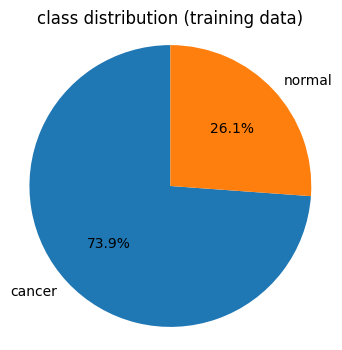

In [ ]:
# Visualization of Training Data Class Distribution Using Pie Chart

plt.figure(figsize=(4, 4))
plt.pie(
    counts,
    labels=class_names,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("class distribution (training data)")
plt.axis("equal")
plt.show()

In [ ]:
# Utility Function for Visualizing Sample Images per Class from a Data Generator
    
def plot_sample_images(generator, class_names, samples_per_class=3):
    images, labels = next(generator)
    labels = labels.astype(int)

    plt.figure(figsize=(6, 6))
    plotted = {i: 0 for i in range(len(class_names))}
    index = 1

    for img, label in zip(images, labels):
        if plotted[label] < samples_per_class:
            plt.subplot(len(class_names), samples_per_class, index)
            plt.imshow(img)
            plt.title(class_names[label])
            plt.axis("off")
            plotted[label] += 1
            index += 1

        if all(v == samples_per_class for v in plotted.values()):
            break

    plt.tight_layout()
    plt.show()

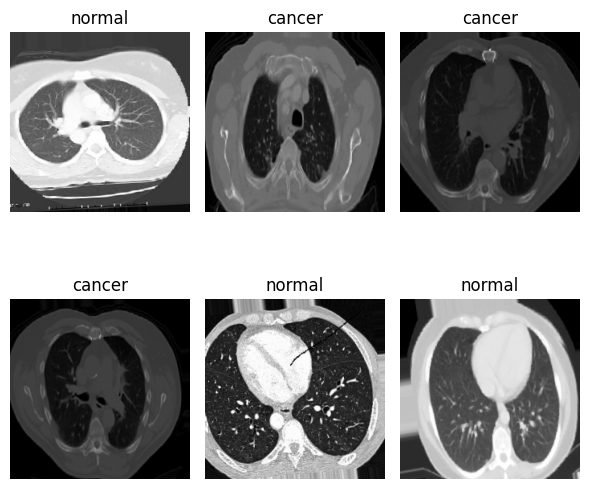

In [ ]:
# Invocation of Sample Image Visualization for Each Class 

class_names = list(train_generator.class_indices.keys())
plot_sample_images(train_generator, class_names)

In [ ]:
# Verification of Image Tensor Shape and Pixel Value Normalization

images, labels = next(train_generator)

print("image shape:", images[0].shape)
print("pixel value range:", images.min(), "to", images.max())

image shape: (224, 224, 3)
pixel value range: 0.0 to 1.0


In [ ]:
# Display of Class Index-to-Label Mapping
print("class index mapping:")
for name, idx in train_generator.class_indices.items():
    print(f"{idx} -> {name}")

class index mapping:
0 -> cancer
1 -> normal


## Model

### Model Architecture

In [ ]:
# Definition of a Custom Convolutional Neural Network (CNN) Architecture for Binary Image Classification

model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu",
                 input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

# 🔑 Binary output
model.add(Dense(1, activation="sigmoid"))

### Model Compilation

In [ ]:
# Model Compilation with Adam Optimizer and Binary Cross-Entropy Loss, Followed by Architecture Summary

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### Training Strategy

In [ ]:
# Configuration of Training Callbacks for Early Stopping, Model Checkpointing, and Learning Rate Reduction

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    "best_binary_cnn.keras",
    monitor="val_loss",
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [ ]:
# Model Training with Validation and Callback Integration

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 912ms/step - accuracy: 0.7208 - loss: 0.6123 - val_accuracy: 0.8413 - val_loss: 0.4762 - learning_rate: 1.0000e-04
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 626ms/step - accuracy: 0.8304 - loss: 0.4950 - val_accuracy: 0.9206 - val_loss: 0.3361 - learning_rate: 1.0000e-04
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 572ms/step - accuracy: 0.8339 - loss: 0.4647 - val_accuracy: 0.9683 - val_loss: 0.2972 - learning_rate: 1.0000e-04
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 768ms/step - accuracy: 0.8781 - loss: 0.3669 - val_accuracy: 0.9841 - val_loss: 0.1276 - learning_rate: 1.0000e-04
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 785ms/step - accuracy: 0.8922 - loss: 0.3102 - val_accuracy: 1.0000 - val_loss: 0.1088 - learning_rate: 1.0000e-04
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 688ms/step - accuracy: 0.9170 - loss: 0.2342 - val_accuracy: 1.0000 - val_loss: 0.0484 - learning_rate: 1.0000e-04
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 642ms/step - acc

### Model Evaluation

In [ ]:
# Evaluation of Trained Model Performance on Test Dataset

test_loss, test_accuracy = model.evaluate(test_generator)

print(f"test accuracy: {test_accuracy:.4f}")
print(f"test loss: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.9460 - loss: 0.1380
test accuracy: 0.9460
test loss: 0.1380


### Prediction & Inference

In [ ]:
# Generation of Binary Predictions and Extraction of True Labels from Test Data

y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

y_true = test_generator.classes

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step


### Performance Analysis & Reporting

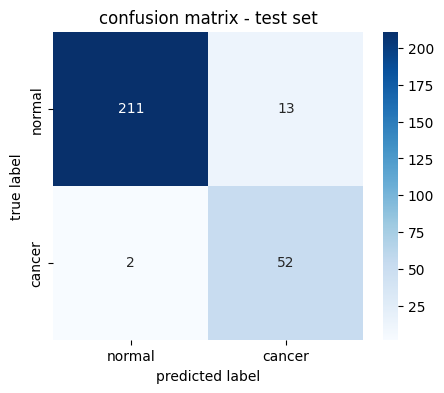

In [ ]:
# Confusion Matrix Visualization for Binary Classification Results on Test Data

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["normal", "cancer"],
    yticklabels=["normal", "cancer"]
)
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.title("confusion matrix - test set")
plt.show()


In [ ]:
# Detailed Classification Performance Report for Binary Lung Cancer Detection

print(
    classification_report(
        y_true,
        y_pred,
        target_names=["normal", "cancer"]
    )
)

              precision    recall  f1-score   support

      normal       0.99      0.94      0.97       224
      cancer       0.80      0.96      0.87        54

    accuracy                           0.95       278
   macro avg       0.90      0.95      0.92       278
weighted avg       0.95      0.95      0.95       278



In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_prob)

print("Evaluation Metrics:")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")


Evaluation Metrics:
Accuracy  : 0.9460
Precision : 0.8000
Recall    : 0.9630
F1-score  : 0.8739
ROC-AUC   : 0.9829


In [ ]:
model.save(r"\HealthAI\models\image_diagnosis\lung_cancer_cnn.keras")